# HW2
note by : 슈하다 2022320107

# 7. Convolutional Neural Networks

##7.1 From Fully Connected Layers to Convolutions

**Fully Connected Networks (MLPs)**:

- MLPs are effective for tabular data, where rows are examples, and columns are features.

- High-dimensional perceptual data (like images) make MLPs impractical because of the immense number of parameters required.

**Convolutional Neural Networks (CNNs)**:

- They exploit structured patterns in images.

- Images contain local and spatial structures that CNNs use to reduce the number of parameters required.

###7.1.1 Invariance

- The network should respond similarly to the same object, no matter its position in the image. **(translation invariance)**

- The early layers of a CNN should focus on small regions (patches) of the image. **(locality principle)**

- As we move deeper into the network, the CNN can capture more global (longer-range) features.

###7.1.2 Constraining the MLP

1. MLPs with Image Inputs:

- Instead of treating the inputs as a flat vector, consider a two-dimensional image input $𝑋$ and a hidden representation
$𝐻$, both structured as matrices.
- This idea implies that both the input and the hidden layers have spatial structure, retaining the two-dimensional grid of pixels.

2. Fourth-Order Weight Tensors:

- In a traditional MLP, weights between input and hidden layers are matrices.

- However, with two-dimensional inputs and hidden layers, we need a fourth-order weight tensor $𝑊$ to represent the connections between all input pixels and hidden units.

- The fully connected layer can be expressed as:

  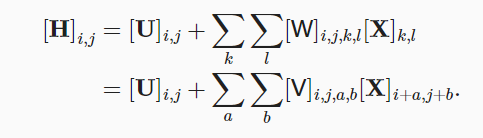

The image shows how to compute a hidden layer value $[H]_{i,j}$​ using an input $[X]$ and weight tensors $[W]$ and $[V]$.

- The switch from $[W]$ to $[V]$ is just a change in notation to make things simpler, without changing the actual process.

- For each position $(i,j)$ in the hidden layer, the value is calculated by adding up pixels from the input around $(i,j)$, weighted by $[V]$.

- A single layer with a large 1000x1000 image would need $10^{12}$ parameters, which is too much for current computers to handle.










####7.1.2.1

**Translation invariance**, which ensures that a shift in the input image results in a corresponding shift in the hidden representation.

- The weights no longer depend on the absolute position of pixels. Instead, the same weights $W$ are applied across different regions of the image, reducing the number of parameters significantly.

**Convolution**: The new formulation where the weights do not depend on the pixel location leads to a **convolution operation**.

- The output $H$ at each location $(i,j)$ is computed by applying a weighted sum (using a small filter) to a local neighborhood of the input:

    $H\_{i,j} = \\sum\_{a,b} X\_{i+a,j+b} w\_{a,b}$

    This reduces the number of parameters to $k \times k$ (where $k$ is the size of the filter), a drastic reduction compared to the fully connected layer's parameter count.”










####7.1.2.2

**Locality Principle**: The locality principle suggests that to understand what is happening at a particular pixel $(i,j)$, the network should only need to look at nearby pixels.

- This means that weights connecting a pixel to a hidden unit should have a limited **receptive field** (a local neighborhood), reducing the number of weights.

- By applying this locality principle, we restrict the weights $w_{a,b}$, in the convolution filter to a smaller region around each pixel.

- Instead of each hidden unit being connected to all input pixels, each hidden unit is only connected to a small neighborhood of pixels. This results in significantly fewer parameters.

  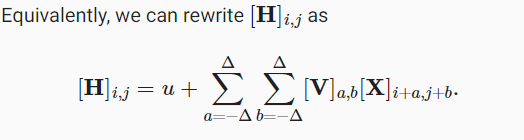






###7.1.3 Convolutions

In mathematics, the convolution between two functions, say $f$, $g$ : $\mathbb{R}^d \to \mathbb{R}$ is defined as

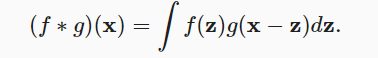

That is, we measure the overlap between and when one function is “flipped” and shifted by $x$.

Whenever we have discrete objects, the integral turns into a sum. For instance, for vectors from the set of square-summable infinite-dimensional vectors with index running over
$\mathbb{Z}$ we obtain the following definition:

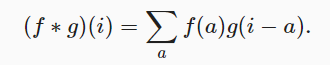


In the context of discrete data, like images, the integral becomes a sum, and for two-dimensional tensors (like images), it looks like this:

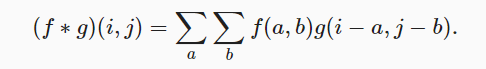

CNNs perform a **cross-correlation** rather than a strict mathematical convolution. In cross-correlation, we use the direct values $f(i+a,j+b)$ instead of $f(i−a,j−b)$, which means we don't flip the kernel.







###7.1.4 Channels

1. **Multichannel Images**:

- Images are not just two-dimensional (height and width), but are actually **third-order tensors** because they consist of multiple **color channels** (typically Red, Green, and Blue). Thus, the shape of an image is typically $H \times W \times 3$, where $H$ is the height, $W$ is the width, and 3 represents the color channels.

2. **Adapting Convolutional Filters**:

- Convolutional filters must adapt to handle these multiple channels. Instead of a 2D filter $w$ (for grayscale images), we now have a filter $W$ that operates on 3D inputs, meaning it spans the channels (e.g., for RGB input images).

- If the input image has $c_{\text{in}}$​ channels, then the filter $W$ has the shape $k \times k \times $$ c_{\text{in}}$, where $k$ is the size of the convolutional kernel.

3. **Hidden Representations with Channels**:

- In addition to the input images having multiple channels, the **hidden layers** also typically have multiple channels. Each spatial location in the hidden representation is associated with a vector of values instead of a single value, forming **feature maps**.

- These hidden channels (or feature maps) capture different aspects of the image. For example, some channels might detect edges, while others detect textures or shapes.

  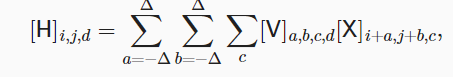







## 7.2 Convolutions for Images

In [ ]:
pip install d2l

In [ ]:
import torch
from torch import nn
from d2l import torch as d2l

###7.2.1 The Cross-Correlation Operation

The **cross-correlation operation** is at the heart of how convolutional layers process input data, typically images.

Concept Overview:

- Input Tensor: A 2D grid representing pixel intensities of the image (without considering channels for now). For example, an image with a height and width of 3 pixels would be a $3×3$ tensor.

- Kernel (Filter): A small matrix of learnable parameters that slides over the image and performs elementwise multiplication with the pixels it overlaps with, followed by summing the results. The kernel has its own height and width, typically smaller than the image (e.g.,
$2×2$).

- Output Tensor: A 2D grid where each element is the result of applying the kernel to a corresponding region of the input image.

Cross-Correlation Operation:

1. Sliding the Kernel:

    - The kernel starts at the upper-left corner of the input image.
    - At each position, the kernel covers a part of the image (called a window or subtensor), and elementwise multiplication is performed between the kernel's values and the corresponding pixel values.
    - The result of this multiplication is summed to produce a single scalar, which is placed in the corresponding location of the output tensor.

2. Moving the Kernel:

    - The kernel shifts across the image, sliding one position at a time (from left to right, and then top to bottom) to compute the next value in the output tensor.
    - This continues until the kernel has covered the entire image, though the size of the output tensor is usually smaller than the input tensor, since the kernel can’t fully cover the edges.

3. Output Size:

    - If the input image has a height and width of $n_{h}×n_{w}$, and the kernel has a height and width of $k_{h} \times k_{w}$, the height and width of the output tensor will be reduced by the kernel’s dimensions:

    $Output Height\=n_{h}−k_{h}​+1$
    
    $Output Width\=n_{w}−k_{w}+1$


In [ ]:
def corr2d(X, K):
  """Compue 2D cross-correlation."""
  h, w = K.shape
  Y = torch.zeros((X.shape[0] - h + 1, X.shape[1] - w + 1))
  for i in range(Y.shape[0]):
    for j in range(Y.shape[1]):
      Y[i, j] = (X[i:i + h, j:j +w] * K).sum()
  return Y

In [ ]:
X = torch.tensor([[0.0, 1.0, 2.0], [3.0, 4.0, 5.0], [6.0, 7.0, 8.0]])
K =torch.tensor([[0.0, 1.0], [2.0, 3.0]])
corr2d(X, K)

###7.2.2 Convolutional Layers

A **convolutional layer** is essentially a mechanism that applies the cross-correlation operation to an input tensor using a kernel (filter), followed by adding a scalar bias. The key parameters of a convolutional layer are:

1. Kernel (Filter): A small matrix used to detect patterns (e.g., edges, textures) within the image. Each filter's weights are initialized randomly during the training phase.

2. Bias: A scalar added after the convolution to help shift the activation function, aiding the model in making more nuanced predictions.

In [ ]:
class Conv2D(nn.Module):
  def __init__(self, kernel_size):
    super().__init__()
    self.weight = nn.Parameter(torch.rand(kernel_size))
    self.bias = nn.Parameter(torch.zeros(1))

  def forward(self, x):
    return corr2d(x, self.weight) + self.bias

###7.2.3 Object Edge Detection in Images

A practical application of convolutional layers is **detecting object edges in images** by identifying pixel intensity changes between adjacent pixels, which are interpreted as edges.

- The kernel $K$ has a height of 1 and a width of 2.

- When performing cross-correlation, if two horizontally adjacent pixels are the same, the output is 0. If they differ, the output is non-zero.

- This is a finite difference operator that approximates the first derivative in the horizontal direction.

- The difference between two horizontally adjacent pixel values at position $(i,j)$ is calculated as $x_{i,j} - x_{i+1,j}​$.

The formula $-\partial_{i} f(i,j)$ represents the derivative of function $f(i,j)$ with respect to iii, approximated by the difference of values over a small interval.”

Cross-Correlation for Edge Detection:

When the kernel is applied to the image, it identifies changes as follows:

1. Edge from White to Black: This will result in a positive output (1).

2. Edge from Black to White: This will result in a negative output (-1).

3. Same adjacent values: This results in a zero output (0).

Vertical Edge Detection :

- Detect vertical edges by transposing the image and applying a kernel designed for vertical changes.

- If use a horizontal edge-detecting kernel on a transposed image, it won’t detect vertical edges because it is meant for horizontal differences.

- To detect vertical edges, use a kernel that compares vertical pixels (like a $2×1$ kernel).






In [ ]:
X = torch.ones((6, 8))
X[:, 2:6] = 0
X

In [ ]:
K = torch.tensor([[1.0, -1.0]])

In [ ]:
Y = corr2d(X, K)
Y

In [ ]:
corr2d(X.t(), K)

###7.2.4 Learning a Kernel


**Learning** **Kernels** **in Convolutional Layers**:

1. Creating the Convolutional Layer

  - Start with a randomly initialized kernel in the convolutional layer. It performs cross-correlation between the image and kernel to produce an output.

2. Defining the Loss Function

  - Measure the error by comparing the layer’s output to the expected result using squared error

3. Updating the Kernel (Gradient Descent)

  - Use backpropagation to adjust the kernel weights to reduce the error

4. Iterative Optimization

  - Repeat this process, updating the kernel after each iteration until the output improves and the error decreases.

5. Learning the Desired Kernel

  - Over time, the learned kernel will closely resemble the ideal kernel, such as an edge detector.

6. Example:

  - If the target kernel is [1, −1] for detecting edges, training will adjust the random kernel until it matches the desired one.

In [ ]:
# Construct a two-dimensional convolutional layer with 1 output channel and a
# kernel of shape (1, 2). For the sake of simplicity, we ignore the bias here
conv2d = nn.LazyConv2d(1, kernel_size=(1, 2), bias = False)

# The two-dimensional convolutional layer uses four-dimensional input and
# output in the format of (example, channel, height, width), where the batch
# size (number of examples in the batch) and the number of channels are both 1
X = X.reshape((1, 1, 6, 8))
Y = Y.reshape((1, 1, 6, 7))
lr = 3e-2 #Learning rate

for i in range(10):
  Y_hat = conv2d(X)
  l = (Y_hat - Y) ** 2
  conv2d.zero_grad()
  l.sum().backward()
  # Update the kernel
  conv2d.weight.data[:] -= lr * conv2d.weight.grad
  if (i + 1) % 2 == 0:
    print(f'epoch {i + 1}, loss {l.sum():.3f}')

In [ ]:
conv2d.weight.data.reshape((1, 2))

###7.2.5 Cross-Correlation and Convolution

- Strict **Convolution** involves flipping the kernel both horizontally and vertically before sliding it over the input image and performing the dot product.

- **Cross-Correlation** skips the flipping step and directly applies the kernel to the input image.

CNNs often learn the kernel through training. The model will still be able to capture meaningful patterns because the kernel is learned. If we change from cross-correlation to strict convolution, the only change will be that the learned kernel will need to be flipped to maintain the same output.

###7.2.6 Feature Map and Receptive Field

Feature Map:

- The output of a convolutional layer, showing learned spatial features (e.g., edges, textures) from the input image.

- Each element in the feature map responds to a specific feature detected by the layer’s kernel.

Receptive Field:

- The region of the input image that affects the output of a neuron in a convolutional layer.

- Influencing Factors:

  - Kernel Size: Larger kernels mean larger receptive fields.

  - Network Depth: Deeper layers combine info from previous layers, increasing the receptive field.

Deeper layers allow CNNs to detect broader, more complex features, moving from local details (like edges) to global features (like shapes and objects).

##7.3 Padding a Stride

###7.3.1 Padding

1. Purpose of Padding: When applying convolutional layers, pixels on the edge of the image tend to get lost, reducing the output's size. Padding helps solve this problem by adding extra pixels around the image's boundary, ensuring that the convolutional operation covers the entire image.

2. Effect on Output Size: Padding increases the effective size of the input image. For example, padding a $3 \times 3$ input with zeros increases its size to $5 \times 5%. The formula for the output shape with padding is given by:

    $(n_h - k_h + p_h + 1) \times (n_w - k_w + p_w + 1)$

    where $n_h, n_w$​ are the input's height and width, $k_h, k_w$​ are the kernel sizes, and $p_h, p_w$ are the padding added to height and width.

  Padding values are typically set to keep the output size the same as the input size, which is convenient for constructing deeper networks. This is done by setting the padding to half the kernel size (rounded down if necessary).

3. Odd vs Even Kernels: Using odd-sized kernels (e.g., $1 \times 1$, $3 \times 3$, $5 \times 5$) is common because it ensures that padding is symmetric, preserving the image’s center alignment after convolution.”








In [ ]:
# We define a helper function to calculate convolutions. It initializes the
# convolutional layer weights and performs corresponding dimensionality
# elevations and reductions on the input and output
def comp_conv2d(conv2d, X):
  # (1, 1) indicates that batch size and the number of channels are both 1
  X = X.reshape((1, 1) + X.shape)
  Y = conv2d(X)
  # Strip the first two dimensions: examples and channels
  return Y.reshape(Y.shape[2:])

# 1 row and column is padded on either side, so a total of 2 rows or columns
# are added
conv2d = nn.LazyConv2d(1, kernel_size=3, padding=1)
X = torch.rand(size=(8, 8))
comp_conv2d(conv2d, X).shape

In [ ]:
# We use a convolution kernel with height 5 and width 3. The padding on either
# side of the height and width are 2 and 1, respectively
conv2d = nn.LazyConv2d(1, kernel_size=(5, 3), padding=(2, 1))
comp_conv2d(conv2d, X).shape

###7.3.2 Stride

1. Definition: Stride refers to the number of pixels by which the convolutional window shifts as it moves across the input image. It can be applied both vertically and horizontally.

2. Impact on Output Size: The stride controls how much the output shrinks compared to the input. A larger stride results in a smaller output because the convolution skips pixels. The output size can be computed using the formula:

  $⌊(n_h​−k_h​+p_h​+s_h) \div s_h​​⌋×⌊(​n_w​−k_w​+p_w​+s_w) \div s_w
  ​​⌋$

3. Effect of Stride on the Convolution Process: A stride larger than 1 means the convolution window will jump by multiple pixels, reducing overlap between regions and lowering the resolution of the output feature map.

In [ ]:
conv2d = nn.LazyConv2d(1, kernel_size=3, padding=1, stride=2)
comp_conv2d(conv2d, X).shape

In [ ]:
conv2d = nn.LazyConv2d(1, kernel_size=(3, 5), padding=(0, 1), stride=(3, 4))
comp_conv2d(conv2d, X).shape

##7.4 Multiple Input and Multiple Output Channels

###7.4.1 Multiple Input Channels

- If the input data has C_in channels, the convolution kernel must also have C_in input channels.

- Each channel of the input tensor is convolved with its corresponding channel in the kernel tensor, and the results are summed to produce the output.

In [ ]:
def corr2d_multi_in(X, K):
  # Iterate through the 0th dimension (channel) of K first, then add them up
  return sum(d2l.corr2d(x, k) for x, k in zip(X, K))

In [ ]:
X = torch.tensor([[[0.0, 1.0, 2.0], [3.0, 4.0, 5.0], [6.0, 7.0, 8.0]],
                  [[1.0, 2.0, 3.0], [4.0, 5.0, 6.0], [7.0, 8.0, 9.0]]])
K = torch.tensor([[[0.0, 1.0], [2.0, 3.0]], [[1.0, 2.0], [3.0, 4.0]]])

corr2d_multi_in(X, K)

###7.4.2 Multiple Output Channels

1. **Richer Feature Learning**: Multiple output channels allow CNNs to detect a variety of features (like edges, textures, or patterns) at each layer. Each channel learns different aspects of the input image.

2. **Increased Depth**: As you go deeper into a CNN, it’s common to increase the number of output channels while reducing the spatial size of the feature maps (height and width). This balances detail with the ability to detect complex features.

3. **Collaborative Learning**: Output channels don’t operate independently. They work together to provide a richer, more comprehensive representation of the input data.

4. **Cross-Correlation**: Each output channel is created by applying its corresponding kernel to all input channels, combining information from multiple perspectives of the input.

In [ ]:
def corr2d_multi_in_out(X, K):
  # Iterate through the 0th dimension of K, and each time, perform
  # cross-correlation operations with input X. All of the results are
  # stacked together
  return torch.stack([corr2d_multi_in(X, k) for k in K], 0)

In [ ]:
K = torch.stack((K,K + 1, K + 2), 0)
K.shape

In [ ]:
corr2d_multi_in_out(X, K)

###7.4.3 $1$   $X$   $1$ Convolutional Layer

- 1x1 Convolution (Pointwise Convolution):

  - Operates on the depth (number of channels) of the input, not the spatial dimensions (height/width).
  - Each pixel's channels are combined linearly, allowing feature interaction across channels.
   - Common in advanced CNN architectures like Inception and ResNet for dimensionality reduction and feature extraction.

- Key Points:

  - Weight Sharing: Like regular convolutions, 1x1 convolutions share weights across all spatial locations.
  - Acts as Fully Connected Layer: You can think of it as applying a fully connected layer to each pixel, transforming input values to output values through a linear combination of input channels.

- Purpose: Alters channel depth without affecting height or width, making it efficient for learning complex features.

In [ ]:
def corr2d_multi_in_out_1x1(X, K):
  c_i, h, w = X.shape
  c_o = K.shape[0]
  X = X.reshape((c_i, h*w))
  K =K.reshape((c_o, c_i))
  # Matrix multiplication in the fully connected layer
  Y = torch.matmul(K, X)
  return Y.reshape((c_o, h, w))

In [ ]:
X = torch.normal(0, 1, (3, 3, 3))
K = torch.normal(0, 1, (2, 3,  1, 1))
Y1 = corr2d_multi_in_out_1x1(X, K)
Y2 = corr2d_multi_in_out(X, K)
assert float(torch.abs(Y1 - Y2).sum()) < 1e-6

##7.5 Pooling

###7.5.1 Maximum Pooling and Average Pooling

- Pooling operations consist of a fixed-size window that moves over the input tensor, computing a single output value for each location.

- They apply deterministic operations such as maximum pooling (max pooling) and average pooling.

  - Max Pooling: For each region defined by the pooling window, the maximum value is selected. This operation helps retain the most significant features from the input while discarding less relevant information.

  - Average Pooling: This operation calculates the average of all values within the pooling window. While average pooling can smooth out noise, it is often less effective than max pooling in capturing salient features.



In [ ]:
def pool2d(X, pool_size, mode='max'):
  p_h, p_w = pool_size
  Y = torch.zeros((X.shape[0] - p_h + 1, X.shape[1] - p_w + 1))
  for i in range(Y.shape[0]):
    for j in range(Y.shape[1]):
      if mode == 'max':
        Y[i, j] = X[i: i + p_h, j: j + p_w].max()
      elif mode == 'avg':
        Y[i, j] = X[i: i + p_h, j: j + p_w].mean()
  return Y

In [ ]:
X = torch.tensor([[0.0, 1.0, 2.0], [3.0, 4.0, 5.0], [6.0, 7.0, 8.0]])
pool2d(X, (2, 2))

In [ ]:
pool2d(X, (2, 2), 'avg')

###7.5.2 Padding and Stride

- **Output Shape Control**: Pooling layers, like convolutional layers, can modify the shape of the feature maps. By adjusting padding and stride, we can control the output dimensions.

- **Padding in Pooling**: Padding ensures the pooling operation works even at the edges of the input, allowing consistent output size.

- **Window Size & Stride**:

  - By default, the pooling window size and stride are often the same (e.g., a 3x3 window with a 3x3 stride).

  - These parameters can be customized for specific network needs.

In [ ]:
X = torch.arange(16, dtype=torch.float32).reshape((1, 1, 4, 4))
X

In [ ]:
pool2d = nn.MaxPool2d(3)
# Pooling has no modl parameters, hence it needs no initialization
pool2d(X)

In [ ]:
pool2d = nn.MaxPool2d(3, padding=1, stride=2)
pool2d(X)

In [ ]:
pool2d = nn.MaxPool2d((2, 3), stride=(2, 3), padding=(0, 1))
pool2d(X)

###7.5.3 Multiple Channels

- **Independent Pooling per Channel**: Pooling is applied separately to each channel in multi-channel input data.

- **Channel Preservation**: The number of channels remains unchanged after pooling, while only the spatial dimensions (height and width) are reduced.

This helps retain important channel-specific features while downsampling the image or feature map.

In [ ]:
X = torch.cat((X, X + 1), 1)
X

In [ ]:
pool2d = nn.MaxPool2d(3, padding=1, stride=2)
pool2d(X)

##7.6 Convolutional Neural Networks (LeNet)

###7.6.1 LeNet

The architecture of LeNet-5 can be summarized as follows:

1. **Input Layer**: Takes a single-channel (grayscale) image, typically $32×32$ pixels, of handwritten digits.

2. **Convolutional Layer 1**:

  - Operation: Convolution with a $5×5$ kernel, producing 6 output channels.
  
  - Activation Function: Sigmoid.

3. **Average Pooling Layer 1**:

  - Operation: Average pooling with a $2×2$ window and a stride of 2, reducing the spatial dimensions.

4. **Convolutional Layer 2**:

  - Operation: Convolution with a 5×5 kernel, producing 16 output channels.

  - Activation Function: Sigmoid.

5. **Average Pooling Layer 2**:

  - Operation: Average pooling with a $2×2$ window and a stride of 2.

6. **Flattening Layer**: Converts the 3D output from the convolutional block into a 2D tensor to prepare for the fully connected layers.

7. **Fully Connected Layer 1**: Outputs 120 features.

8. **Fully Connected Layer 2**: Outputs 84 features.

9. **Output Layer**: Outputs a probability distribution across 10 classes (digits 0-9) using softmax.

**Data Flow in LeNet**

The data flows through LeNet as follows:

- Input images are passed through convolutional layers, where they are transformed into feature maps.

- Pooling layers downsample the feature maps, reducing spatial dimensions while preserving essential features.

- The final feature maps are flattened and passed through fully connected layers, culminating in a probability distribution over the digit classes.

In [ ]:
def init_cnn(module):
  """Initialize weights for CNNs."""
  if type(module) == nn.Linear or type(module) == nn.Conv2d:
    nn.init.xavier_uniform_(module.weight)

class LeNet(d2l.Classifier):
  """The LeNet-5 model."""
  def __init__(self, lr=0.1, num_classes=10):
    super().__init__()
    self.save_hyperparameters()
    self.net = nn.Sequential(
        nn.LazyConv2d(6, kernel_size=5, padding=2), nn.Sigmoid(),
        nn.AvgPool2d(kernel_size=2, stride=2),
        nn.LazyConv2d(16, kernel_size=5), nn.Sigmoid(),
        nn.AvgPool2d(kernel_size=2, stride=2),
        nn.Flatten(),
        nn.LazyLinear(120), nn.Sigmoid(),
        nn.LazyLinear(84), nn.Sigmoid(),
        nn.LazyLinear(num_classes))

In [ ]:
@d2l.add_to_class(d2l.Classifier)
def layer_summary(self, X_shape):
  X = torch.randn(*X_shape)
  for layer in self.net:
    X = layer(X)
    print(layer.__class__.__name__, 'output shape:\t', X.shape)

model = LeNet()
model.layer_summary((1, 1, 28, 28))

###7.6.2 Training

**Steps to Train the LeNet Model**

1. **Load the Dataset**: First, we need to download and prepare the Fashion-MNIST dataset.

2. **Define the Loss Function and Optimizer**: We'll use cross-entropy loss and stochastic gradient descent (SGD) for optimization.

3. **Set Up the Training Loop**: We will iterate over the dataset multiple times (epochs) and update the model parameters based on the computed gradients.

4. **Evaluate the Model**: After training, we will assess the model's performance on a validation or test set.

In [ ]:
trainer = d2l.Trainer(max_epochs=10, num_gpus=1)
data = d2l.FashionMNIST(batch_size=128)
model = LeNet(lr=0.1)
model.apply_init([next(iter(data.get_dataloader(True)))[0]], init_cnn)
trainer.fit(model, data)

#8. Modern Convolutional Neural Networks

##8.2 Networks Using Blocks (VGG)

###8.2.1 VGG Blocks

A VGG block consists of:

1. **Convolutional Layers**: Multiple consecutive convolutional layers with a kernel size of 3, which helps to capture spatial hierarchies.

2. **ReLU Activation Function**: A non-linear activation function applied after each convolution.

3. **Max-Pooling Layer**: A pooling operation with a stride of 2, which reduces the spatial dimensions of the feature maps by half after each block.

The design philosophy of VGG emphasizes depth over width, which proved to be advantageous in capturing more complex features in images. Each block retains spatial resolution through padding, and the network gradually downsamples the feature maps through max-pooling.

In [ ]:
def vgg_block(num_convs, out_channels):
  layers = []
  for _ in range(num_convs):
    layers.append(nn.LazyConv2d(out_channels, kernel_size=3, padding=1))
    layers.append(nn.ReLU())
  layers.append(nn.MaxPool2d(kernel_size=2, stride=2))
  return nn.Sequential(*layers)

###8.2.2 VGG Network

The VGG Network builds on earlier architectures like AlexNet and LeNet but introduces a more organized and scalable design through blocks of layers.

1. **Two Main Components**:

  - **Convolutional Layers**: The first part of VGG extracts features using multiple blocks of convolutional layers and pooling layers.

  - **Fully Connected Layers**: The second part performs classification, similar to AlexNet, based on the extracted features.

2. **VGG Block Structure**:

  - **Convolutional Layers**: Each block contains a sequence of small 3x3 convolutional layers, preserving spatial resolution.

  - **Pooling Layer**: Each block ends with a max-pooling layer, reducing the feature map's size.

3. **Network Configuration**:

  - The architecture is defined by a list of tuples specifying the number of convolutional layers and output channels per block.

  - Example (VGG-11):
    
    - 5 convolutional blocks.
    
    - First 2 blocks have 1 convolutional layer with 64 channels.

    - The last 3 blocks have 2 convolutional layers each, with increasing channels (128, 256, 512).

In [ ]:
class VGG(d2l.Classifier):
  def __init__(self, arch, lr=0.1, num_classes=10):
    super().__init__()
    self.save_hyperparameters()
    conv_blks = []
    for (num_convs, out_channels) in arch:
      conv_blks.append(vgg_block(num_convs, out_channels))
    self.net = nn.Sequential(
        *conv_blks, nn.Flatten(),
        nn.LazyLinear(4096), nn.ReLU(), nn.Dropout(0.5),
        nn.LazyLinear(4096), nn.ReLU(), nn.Dropout(0.5),
        nn.LazyLinear(num_classes))
    self.net.apply(d2l.init_cnn)

In [ ]:
VGG(arch=((1, 64), (1, 128), (2, 256), (2, 512), (2,512))).layer_summary(
    (1, 1, 224, 224))

###8.2.3 Training

In [ ]:
model = VGG(arch=((1, 16), (1, 32), (2, 64), (2, 128), (2, 128)), lr = 0.01)
trainer = d2l.Trainer(max_epochs=10, num_gpus=1)
data = d2l.FashionMNIST(batch_size=128, resize=(224, 224))
model.apply_init([next(iter(data.get_dataloader(True)))[0]], d2l.init_cnn)
trainer.fit(model, data)

##8.6 Residual Networks (ResNet) and ResNeXt


In [ ]:
from torch.nn import functional as F

###8.6.1 Function Classes

In deep learning, understanding the types of functions a neural network can approximate is key to evaluating its expressive power.

1. **Function Classes and Expressive Power**

  - **Function Classes ($𝐹$)**: The set of functions a neural network can approximate, based on its parameters (weights, biases) and hyperparameters (like learning rates).

  - **Truth Function ($𝑓∗$)**: The ideal function we want to approximate. Ideally, it should be within the network’s function class (𝐹).

2. **Optimization Problem**

  - Find an approximation function (𝑓) that minimizes the difference between the predicted output and the true labels (𝑦) in the dataset.

  - This can be formulated as an optimization problem:

    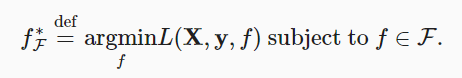


3. **Regularization and Complexity Control**

  - **Regularization**: Helps control the complexity of the function class (𝐹) and improves generalization.

  - Larger datasets often lead to better performance by controlling overfitting.

4. **Function Class Size and Complexity**

  - More complex architectures (𝐹′) can improve the approximation of 𝑓∗, but this isn't always true.

  - A more complex function class may overfit or fail to approximate 𝑓∗ accurately.

5. **Nested vs. Non-Nested Function Classes**

  - **Non-Nested Function Classes**: Increasing the size of the function class (𝐹′) does not always improve approximation. Sometimes, 𝐹′ could perform worse than 𝐹.

  - **Nested Function Classes**: If 𝐹 is nested within 𝐹′ (𝐹 ⊆ 𝐹′), increasing complexity leads to better approximations, as larger function classes contain smaller ones.

6. **Residual Networks (ResNet)**

  - **Residual Networks (ResNet)**: Introduced by He et al. (2016), ResNet solves problems in training deep networks by using residual blocks.

    - **Identity Mapping**: New layers should be able to approximate the identity function, so they don't hurt performance. This helps the network learn more effectively.

    - **Residual Blocks**: These blocks improve gradient flow, making it easier to train deeper networks.

  - Impact: ResNet won the ImageNet competition in 2015 and influenced many models, including Transformers and graph neural networks.

7. **Highway Networks**

- Proposed by Srivastava et al. (2015), Highway Networks were designed to ease training of deep networks, but they lacked the efficient identity mapping used in ResNet.

###8.6.2 Residual Blocks

Residual blocks, a key feature in **ResNet (Residual Networks)**, address the challenges of training very deep neural networks by simplifying the learning process.

1. **Concept of Residual Blocks**

  - **Residual Learning**:
In a typical neural network, the model learns a direct mapping f(x) from the input to the output.

    In a residual block, the model instead learns the residual mapping g(x) = f(x) - x, which simplifies learning, especially if the desired transformation is the identity function (i.e., f(x) = x).

    - **Identity Mapping**:
If the transformation is simply the identity (i.e., the output is the same as the input), the residual mapping becomes F(x) = 0, meaning the network only needs to adjust the weights and biases of the upper layers to achieve the desired result.

  - **Residual Connection**:

    The residual connection (or shortcut connection) is the solid line in the residual block that allows the input to skip the non-linear transformations of the next layers. This helps in better gradient flow during backpropagation, making training deeper networks easier.

  - **Multi-Branch Nature**:

    Residual blocks can be seen as a simplified version of Inception blocks, with one branch learning the identity mapping.

2. **Structure of Residual Blocks**

A typical residual block in ResNet includes:

- **Convolutional Layers**:
Two convolutional layers with the same number of output channels, each followed by:

  - **Batch normalization** (to stabilize learning).
  - **ReLU activation** (to add non-linearity).

- **Skip Connection**:

  After the convolutional layers, the original input x is added directly to the output of the second convolution layer. This sum is then passed through another ReLU activation.

- **Input and Output Shape**:

  For the addition of the input and output to work, the shapes must match. If the output dimensions change (e.g., increasing the number of channels), a 1x1 convolution is used to adjust the input shape to match the output before addition.

- **Spatial Dimensionality Adjustment**:

  To reduce the spatial dimensions (height and width) and increase the number of channels, the 1x1 convolution can be used with strides set to 2. This is especially useful in the first residual block where dimension changes occur.








In [ ]:
class Residual(nn.Module):
  """The Residual block of ResNet models."""
  def __init__(self, num_channels, use_1x1conv=False, strides=1):
    super().__init__()
    self.conv1 = nn.LazyConv2d(num_channels, kernel_size=3, padding=1,
                               stride=strides)
    self.conv2 = nn.LazyConv2d(num_channels, kernel_size=3, padding=1)
    if use_1x1conv:
      self.conv3 = nn.LazyConv2d(num_channels, kernel_size=1,
                                 stride=strides)
    else:
      self.conv3 = None
    self.bn1 = nn.LazyBatchNorm2d()
    self.bn2 = nn.LazyBatchNorm2d()

  def forward(self, X):
    Y = F.relu(self.bn1(self.conv1(X)))
    Y = self.bn2(self.conv2(Y))
    if self.conv3:
      X = self.conv3(X)
    Y += X
    return F.relu(Y)

In [ ]:
blk = Residual(3)
X = torch.randn(4, 3, 6, 6)
blk(X).shape

In [ ]:
blk = Residual(6, use_1x1conv=True, strides=2)
blk(X).shape

###8.6.3 ResNet Model

Architecture Overview

1. **Initial Layers**:

  - The first two layers of ResNet mirror those of GoogLeNet:

    - **Convolutional Layer**: 64 output channels with a stride of 2.

    - **Max-Pooling Layer**: With a stride of 2 to downsample the feature maps.

  - Importantly, ResNet incorporates a batch normalization layer after each convolutional layer, which helps in stabilizing and accelerating training.

2. **Residual Blocks**:

- ResNet replaces the Inception blocks from GoogLeNet with residual blocks.

- Each module contains several residual blocks, all utilizing the same number of output channels.

- The number of channels in the first module matches the number of input channels. Since a max-pooling layer has already been applied, further reduction of height and width is unnecessary.

- For each subsequent module, the number of channels is doubled in the first residual block while the height and width of the feature maps are halved.

3. **Module Composition**:

- ResNet-18 consists of four modules, each containing two residual blocks. Therefore, each module has four convolutional layers (excluding the initial convolutional layer).

- The architecture culminates in a global average pooling layer followed by a fully connected output layer.

- This structure totals 18 layers, leading to the name ResNet-18.

4. **Scalability**:

- By varying the number of channels and residual blocks in each module, other variants of ResNet can be constructed, such as ResNet-152, which has 152 layers.

5. **Simpler Structure**:

- ResNet’s architecture is simpler and more modular than GoogLeNet’s, which allows for greater flexibility in modifications and extensions.


In [ ]:
class ResNet(d2l.Classifier):
  def b1(self):
    return nn.Sequential(
        nn.LazyConv2d(64, kernel_size=7, stride=2, padding=3),
        nn.LazyBatchNorm2d(), nn.ReLU(),
        nn.MaxPool2d(kernel_size=3, stride=2, padding=1))

In [ ]:
@d2l.add_to_class(ResNet)
def block(self, num_residuals, num_channels, first_block=False):
  blk = []
  for i in range(num_residuals):
    if i == 0 and not first_block:
      blk.append(Residual(num_channels, use_1x1conv=True, strides=2))
    else:
      blk.append(Residual(num_channels))
    return nn.Sequential(*blk)

In [ ]:
@d2l.add_to_class(ResNet)
def __init__(self, arch, lr=0.1, num_classes=10):
  super(ResNet, self).__init__()
  self.save_hyperparameters()
  self.net = nn.Sequential(self.b1())
  for i, b in enumerate(arch):
    self.net.add_module(f'b{i+2}', self.block(*b, first_block=(i==0)))
  self.net.add_module('last', nn.Sequential(
      nn.AdaptiveAvgPool2d((1, 1)), nn.Flatten(),
      nn.LazyLinear(num_classes)))
  self.net.apply(d2l.init_cnn)

In [ ]:
class ResNet18(ResNet):
  def __init__(self, lr=0.1,num_classes=10):
    super().__init__(((2, 64), (2, 128), (2, 256), (2, 512)),
                     lr, num_classes)

ResNet18().layer_summary((1, 1, 96, 96))

###8.6.4 Training

In [ ]:
model = ResNet18(lr=0.01)
trainer = d2l.Trainer(max_epochs=10, num_gpus=1)
data = d2l.FashionMNIST(batch_size=128, resize=(96, 96))
model.apply_init([next(iter(data.get_dataloader(True)))[0]], d2l.init_cnn)
trainer.fit(model, data)